In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db



In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath_v15 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

dbpath_v17 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"

dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"

dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"

dbpath_v20 = "/home/idies/workspace/lsst_cadence/FBS_2.0/"

# output directory
dataRawDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/tGaps/'

outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/resultsDb/'
resultsDb = db.ResultsDb(outDir=outDir)


In [4]:
# get the name of all opsim dbs 
import glob

workpath = os.getcwd()
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'

os.chdir(dbpath_v15)  # change to opsim database directory
dblist_v15 = glob.glob('*.db') 

os.chdir(dbpath_v17)  # change to opsim database directory
dblist_v17 = glob.glob('*.db') 

os.chdir(dbpath_v171)  # change to opsim database directory
dblist_v171 = glob.glob('*.db') 

os.chdir(dbpath_v20)  # change to opsim database directory
dblist_v20 = glob.glob('*.db') 


os.chdir(workpath) # change back to work directory

dblist_v15.sort()
dblist_v17.sort()
dblist_v171.sort()
dblist_v20.sort()


In [6]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 save_dT=False, filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        self.save_dT = save_dT
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
        
    def RADec2pix(self, nside, ra, dec, degree=True):
        """
        Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.
    
        Parameters
        ----------
        nside : int
            The nside value of the healpix grid.
        ra : numpy.ndarray
            The RA values to be converted to healpix ids, in degree by default.
        dec : numpy.ndarray
            The Dec values to be converted to healpix ids, in degree by default.
    
        Returns
        -------
        numpy.ndarray
            The healpix ids.
        """
        if degree:
            ra = np.radians(ra) # change to radians
            dec = np.radians(dec)
        
        lat = np.pi/2. - dec
        hpid = hp.ang2pix(nside, lat, ra )
        return hpid


    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = np.sort( dataSlice['observationStartMJD'][idx0] )
        timeCol1 = np.sort( dataSlice['observationStartMJD'][idx1] )

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        #Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        
        dT_tlim = dT[(dT>=self.tmin)&(dT<=self.tmax)] 
        Nv = len(dT_tlim)

        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        if self.save_dT:
            dic = {'Nrun': self.Nrun, 
                'pixId': self.RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                #'Dkl': Dkl,
                # 'FoM_i': FoM_i,
                'dT_lim': dT_tlim
                  }
        else:
            dic = {'Nrun': self.Nrun, 
                'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
                'Nv': Nv,
                #'Dkl': Dkl,
                #'FoM_i': FoM_i,
                # 'dT_lim': dT_tlim
                  }
            
        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
            #f0 = self.fltpair[0]
            #f1 = self.fltpair[1]
            #result = np.min(dT) if len(dT)!=0 else np.inf
            result = Nv
            return float(result) 

        

In [25]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec

def runMetric(dbname, dbpath, fltpair, ipix_ms=None, nside=16, sqlstr=None,
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
              filename=None, dataout=True, **kwargs
             ):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    tmin, tmax: in hours
    """
    opsdb = db.Database(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsMetric( colname=colname, fltpair=fltpair, tmin=tmin, tmax=tmax, bins=bins, mag_lim=mag_lim,
                 filename=filename, dataout=dataout, **kwargs)
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
    

    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}

    if 'observations' in opsdb.get_table_names():
        dbTable='observations' 
    else:
        dbTable = 'SummaryAllProps'
    
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb, dbTable=dbTable )
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky



In [26]:
%%time
# test run for baseline
dbname = dblist_v17[5]
dbpath = dbpath_v17

metricSky = runMetric( dbname=dbname, dbpath=dbpath, fltpair=['g', 'g'], ipix_ms=None, nside=16, sqlstr='proposalId=1 and night<730',
              colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
              tmin=0, tmax=4000, bins=50, mag_lim=[16, 16],
              filename=None, dataout=True, save_dT=True)



Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 44690 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 2.21 s, sys: 1.06 s, total: 3.27 s
Wall time: 7.74 s


In [27]:
arr = metricSky.metricValues.data
arr_valid = arr[ arr != None ]
df = pd.DataFrame.from_records(arr_valid)
df.head(3)

,Nrun,Nv,dT_lim,pixId
0,1,28,"[21.86146420388104, 21.897213682888832, 0.0357...",1376
1,2,28,"[3.98703107041365, 284.10849480609613, 280.121...",1377
2,3,15,"[3.121755713968014, 20.127209143567597, 17.005...",1378


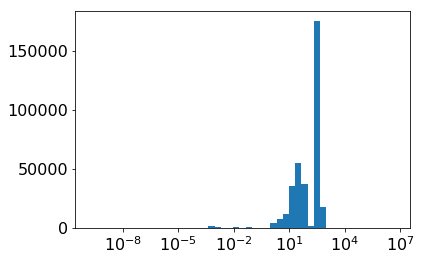

In [37]:
tmin = 5/60/60/24 # in days
tmax = 800
#tmax = 2
bins = np.logspace( np.log(tmin), np.log(tmax), 50)

dT_all = np.concatenate(df.dT_lim )
plt.hist(dT_all, bins=bins);
plt.xscale('log')

### run for all opsims

In [66]:
def get_tgaps_dic(dbpath, dblist):

    sqlstr = 'proposalId=1 and night<730'
    
    tgaps_dic = {}
    
    for dbname in dblist:
        metricSky = runMetric( dbname=dbname, dbpath=dbpath, fltpair=['g', 'g'], ipix_ms=None, nside=16, sqlstr=sqlstr,
                      colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'],
                      tmin=0, tmax=4000, bins=50, mag_lim=[16, 16],
                      filename=None, dataout=True, save_dT=True)
        
        arr = metricSky.metricValues.data
        arr_valid = arr[ arr != None ]
        df = pd.DataFrame.from_records(arr_valid)
        
        tgaps_dic[dbname] = df
        
        print(">>>", dbname)
    return tgaps_dic

In [67]:
tgaps_gg_v17 = get_tgaps_dic(dbpath=dbpath_v17, dblist=dblist_v17)



Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 29699 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> baseline_nexp1_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 27342 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> baseline_nexp2_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint fi

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> euclid_dither3_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 27210 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> euclid_dither4_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 27353 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> euclid_dither5_v1.7_10yrs.db
Hea

Found 26835 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_nm_scale0.4_nslice2_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 26967 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_nm_scale0.4_nslice3_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 26809 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Run

Found 26045 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_scale0.9_nslice3_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 26371 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_scale1.0_nslice2_v1.7_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 26516 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running s

In [68]:
tgaps_gg_v20 = get_tgaps_dic(dbpath=dbpath_v20, dblist=dblist_v20)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 27222 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> baseline_nexp2_v1.7.1_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30622 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> baseline_retrofoot_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint fi

Found 29704 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> long_gaps_nightsoff5_delayed1827_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 29614 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> long_gaps_nightsoff6_delayed-1_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 29719 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
R

Found 30061 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> long_gaps_np_nightsoff7_delayed-1_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 29730 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> long_gaps_np_nightsoff7_delayed1827_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 28651 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce meth

Found 29677 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> presto_half_gap2.0_mix_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30013 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> presto_half_gap2.0_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30205 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statist

Found 29952 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_ns3_rw0.5_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 29370 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> rolling_ns3_rw0.9_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30013 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
C

Found 30113 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> vary_nes_nesfrac0.01_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30047 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
>>> vary_nes_nesfrac0.05_v2.0_10yrs.db
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database observations with constraint filter in ("g", "g") and proposalId=1 and night<730 for columns ['filter', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth', 'fieldDec']
Found 30445 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statist

In [95]:
len(dblist_v17), len(dblist_v20)

(74, 108)

Text(0.5, 0, 'dT')

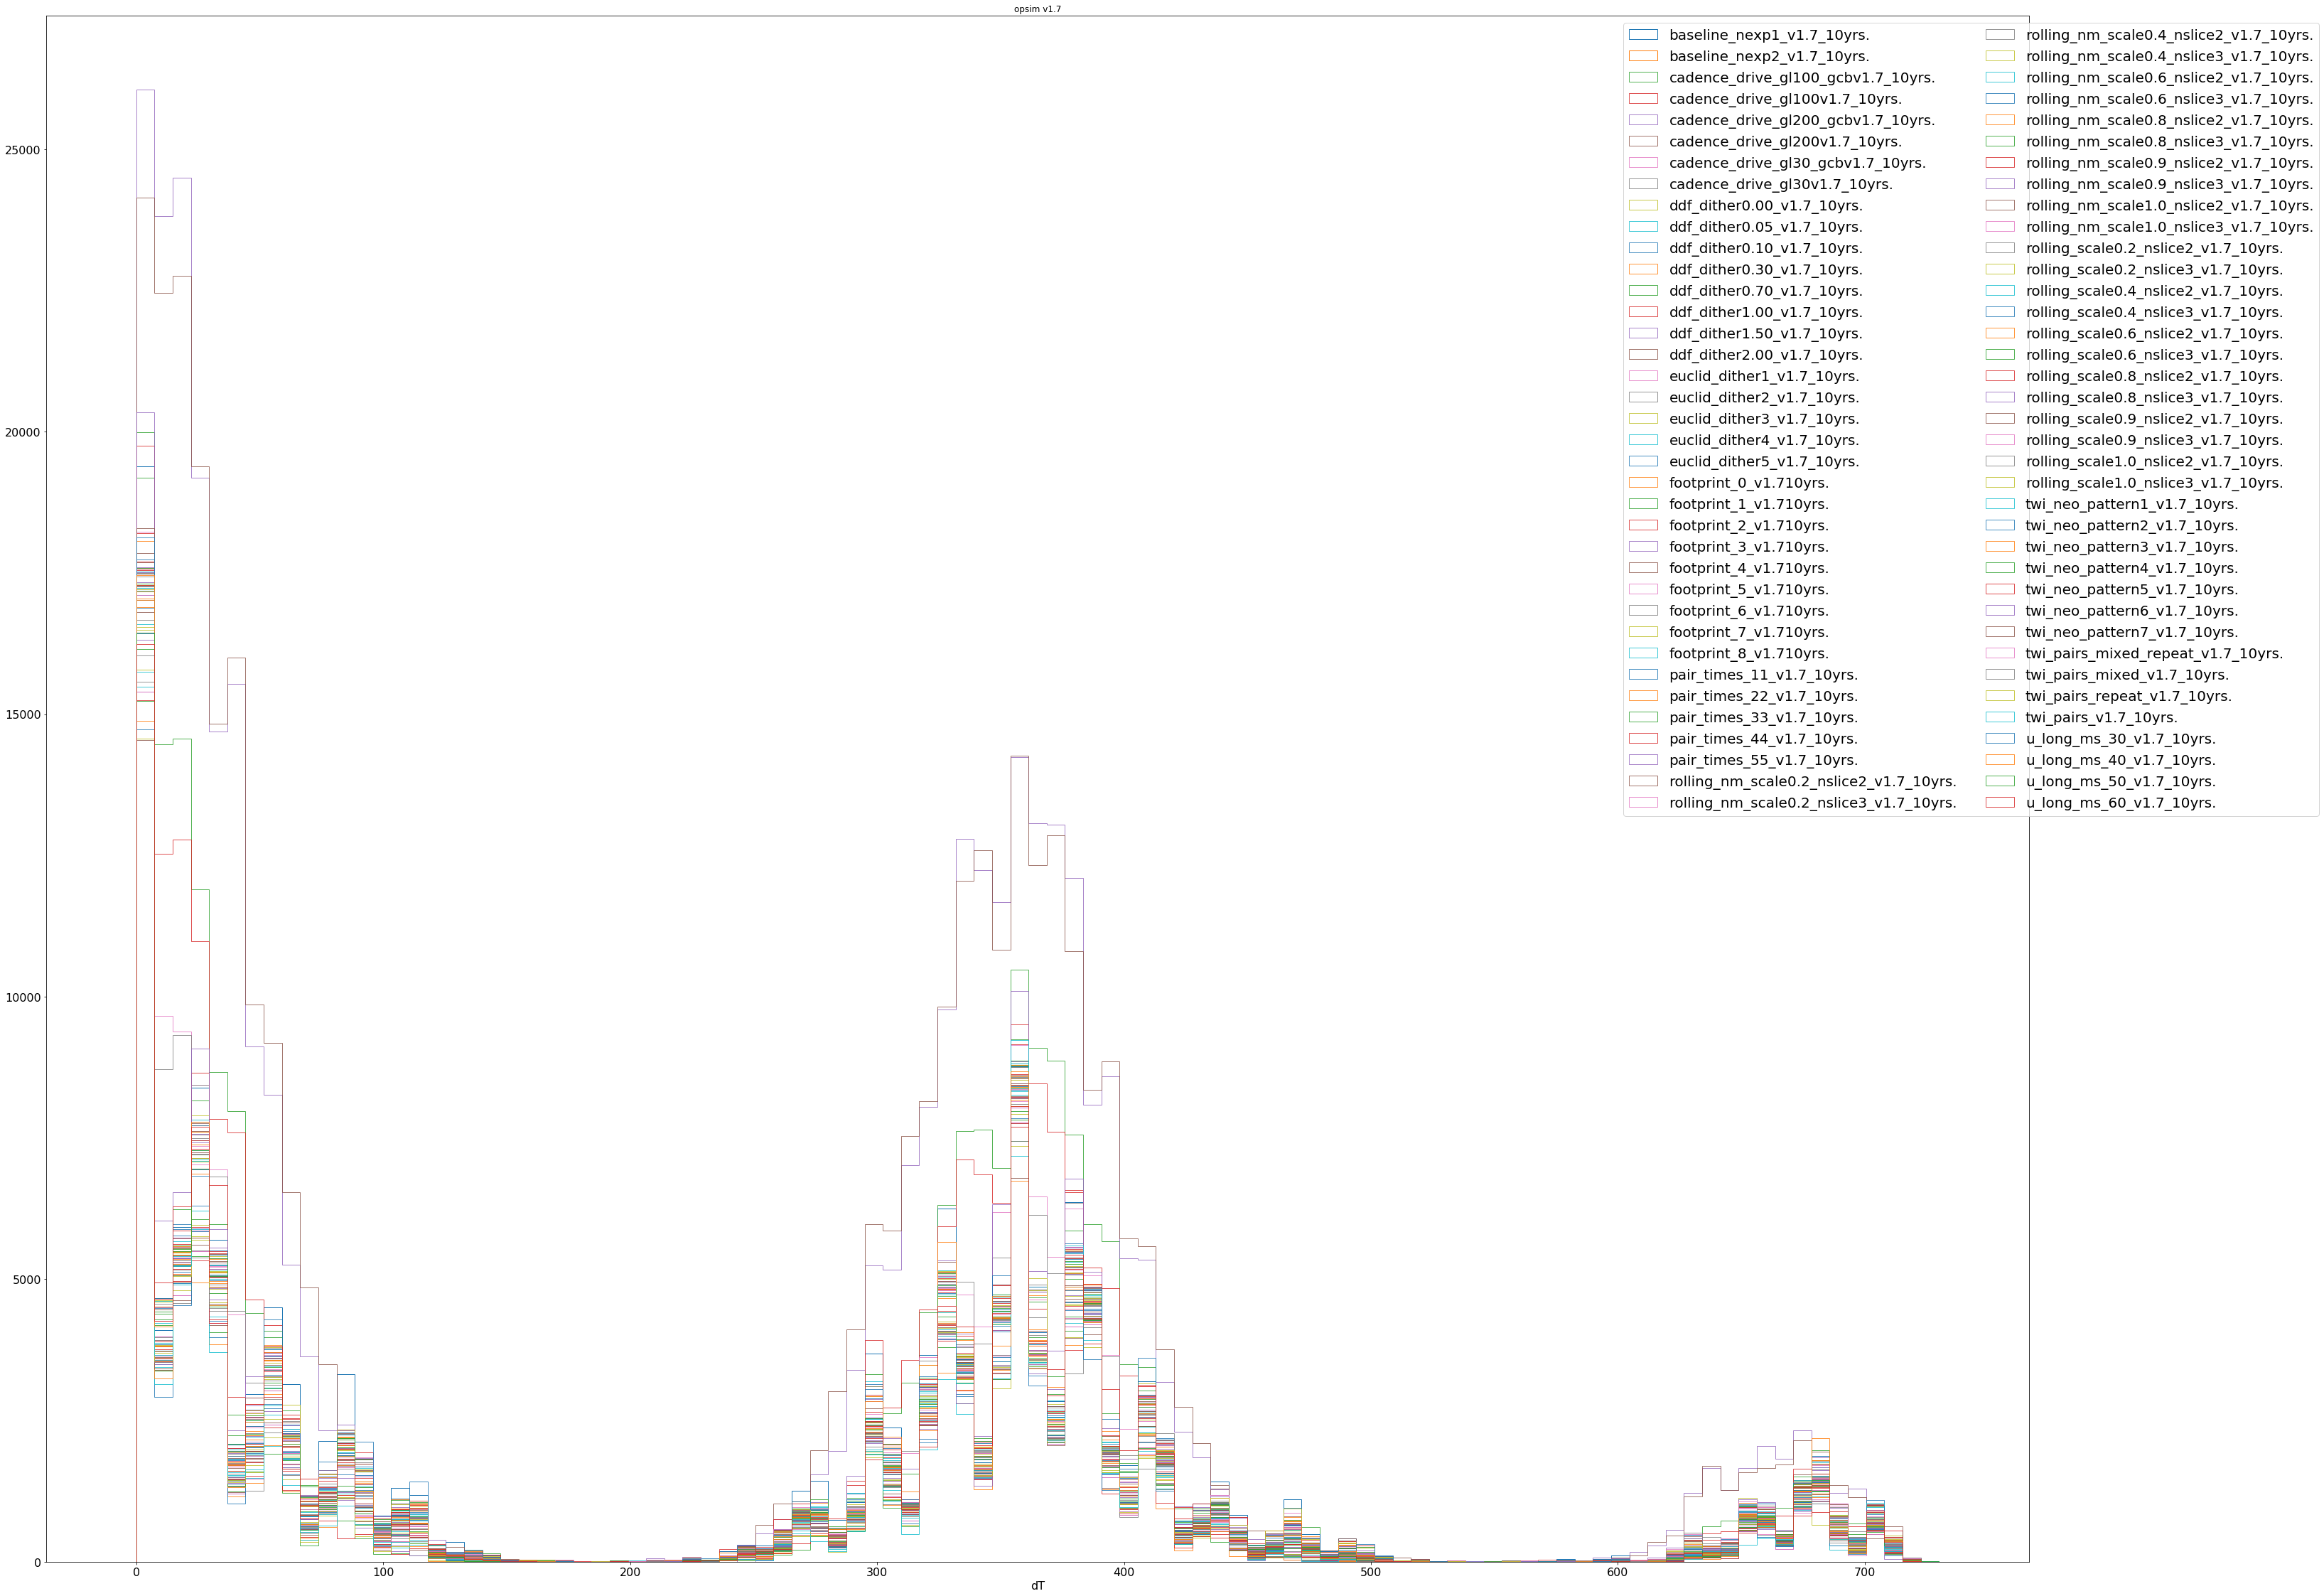

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(50, 40))
#axs = axs.flatten()

#bins = np.logspace( np.log(5/60/60/24), np.log(730), 50)
bins = np.linspace(0, 730, 100)

for i, dbname in enumerate(dblist_v17):
    #ax = axs[i]
    
    df = tgaps_gg_v17[dbname]
    dT_all = np.concatenate(df.dT_lim )
    
    if 'baseline' in dbname:
        alpha = 1
    else:
        alpha = 0.8
    ax.hist(dT_all, bins=bins, alpha=alpha, histtype='step',
            label=dbname.replace('db', ''));
    
    #ax.set_title()
    #ax.set_xscale('log')
ax.legend(bbox_to_anchor=(0.65, 0.5, 0.5, 0.5), ncol=2);
ax.set_title("opsim v1.7")
ax.set_xlabel('dT')

Text(0.5, 1.0, 'opsim v2.0')

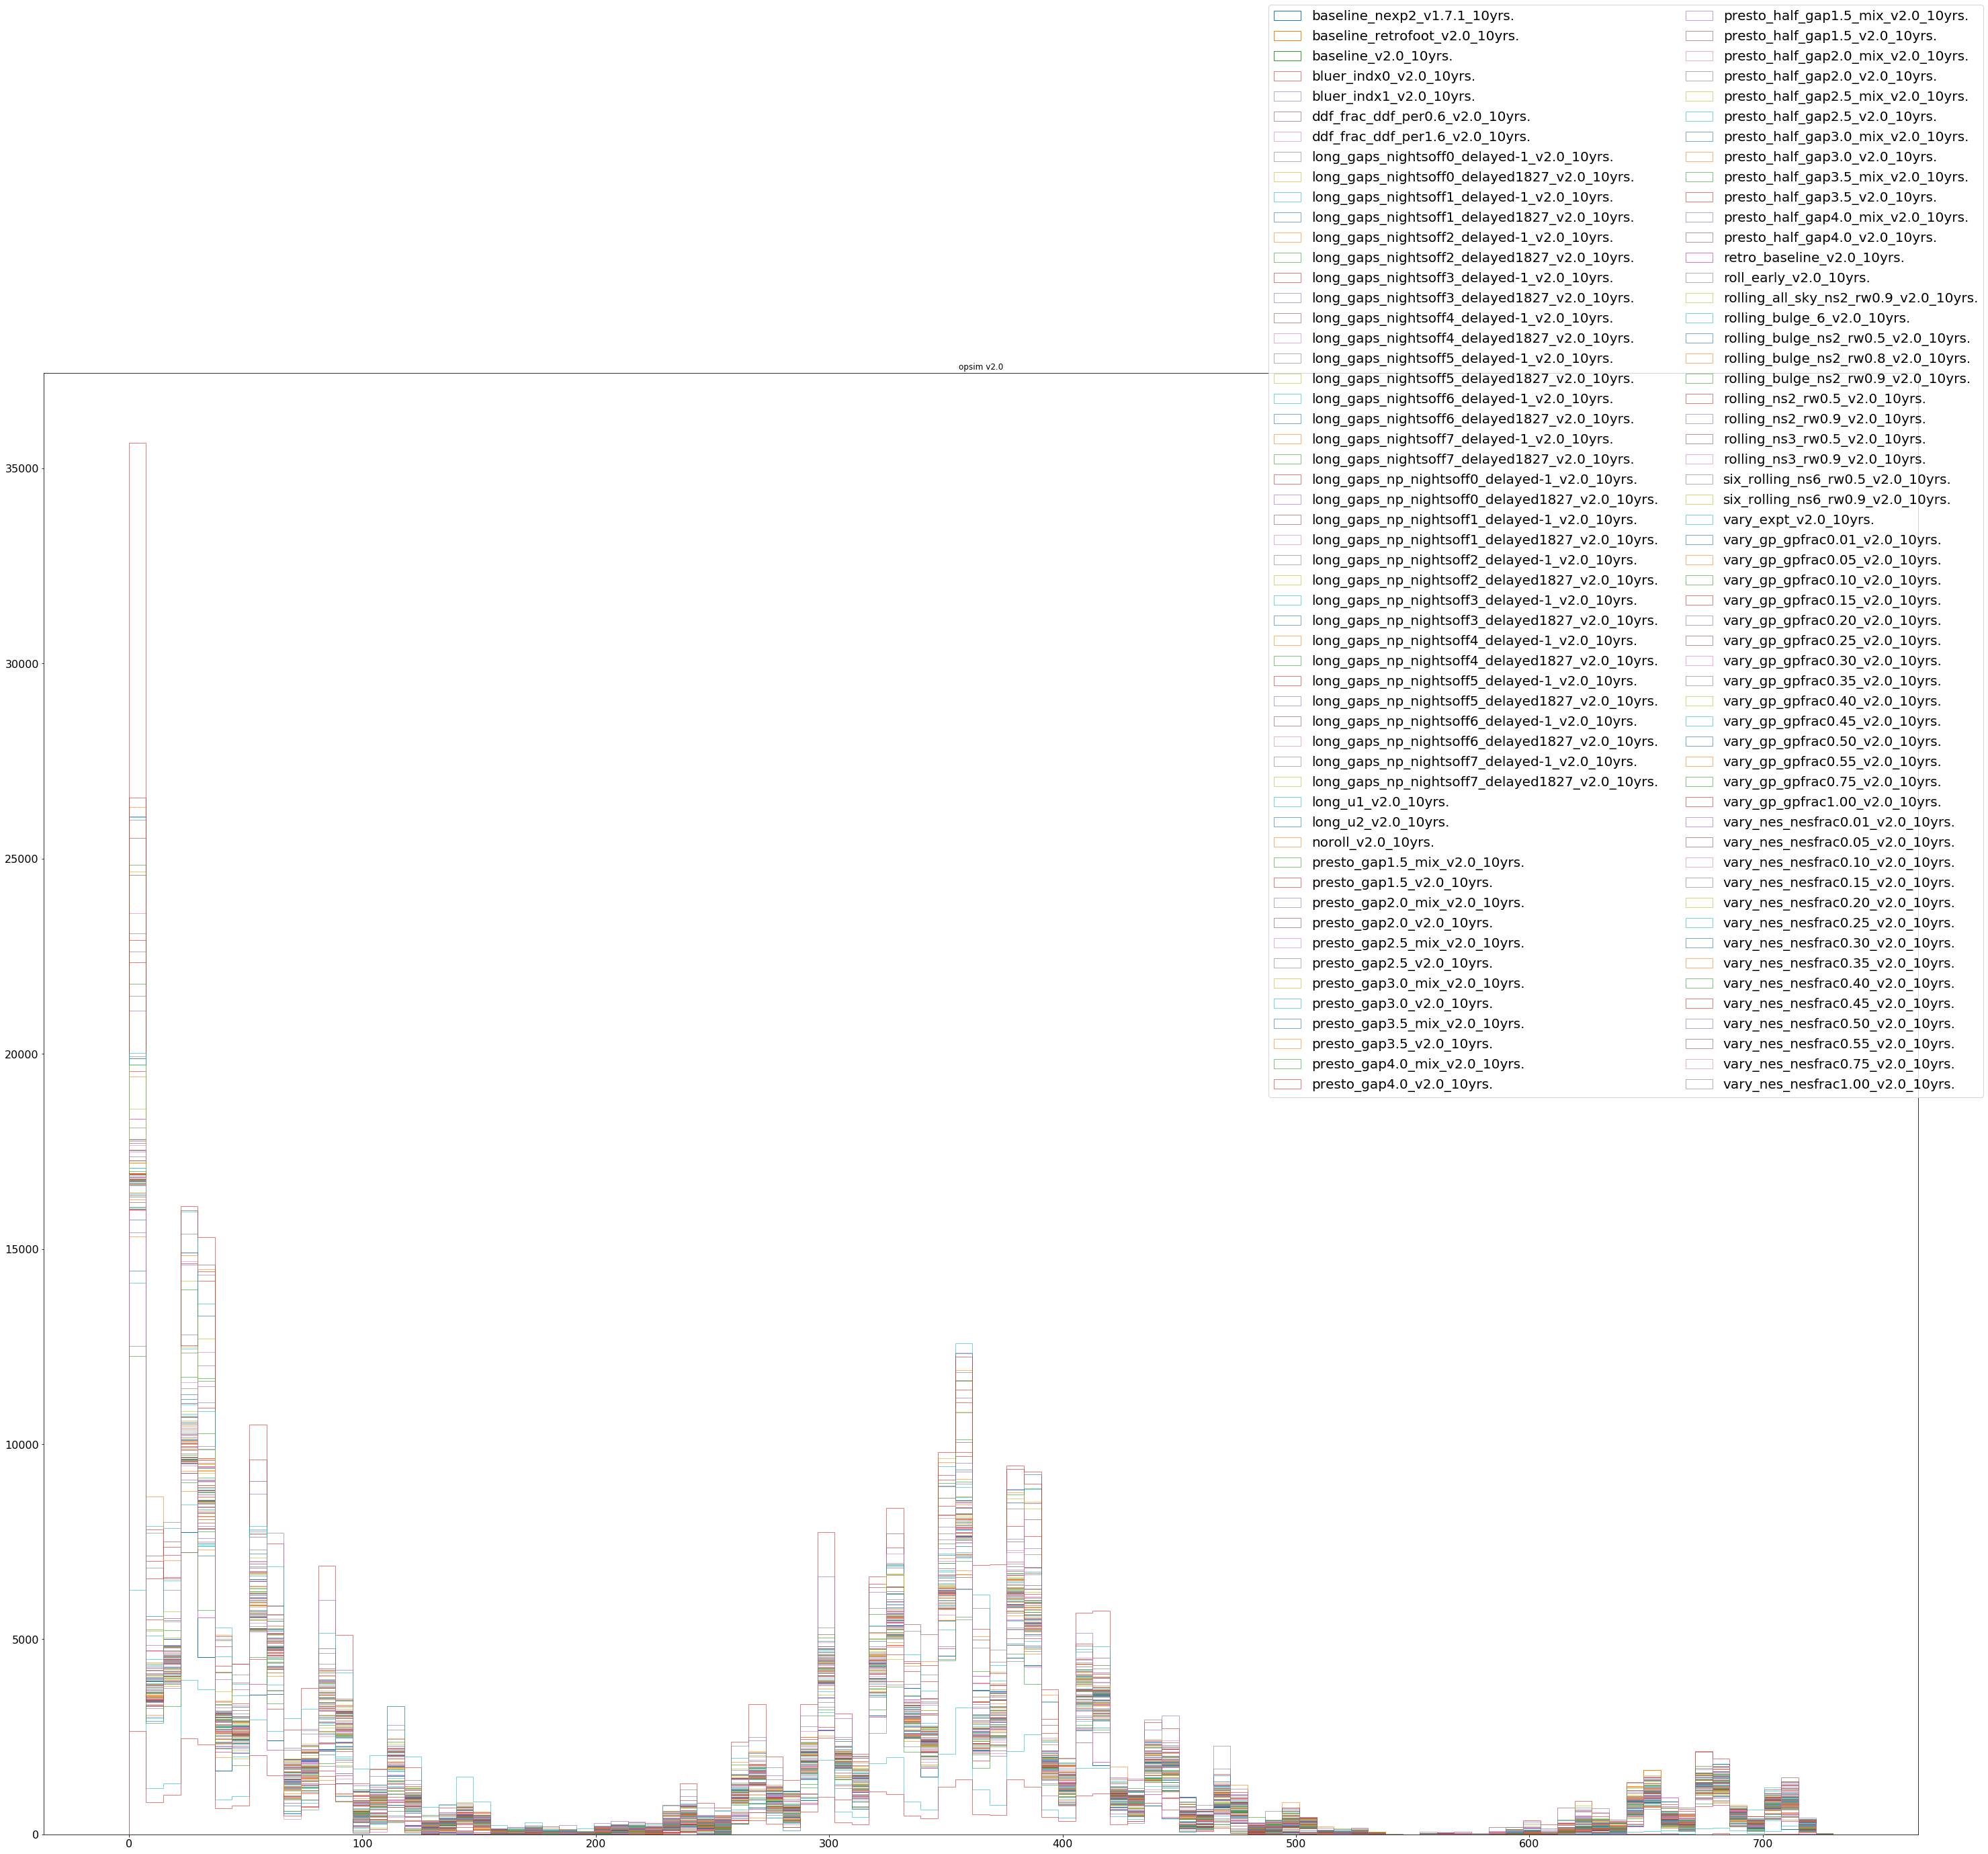

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(50, 40))
#axs = axs.flatten()

#bins = np.logspace( np.log(5/60/60/24), np.log(730), 50)
bins = np.linspace(0, 730, 100)

for i, dbname in enumerate(dblist_v20):
    #ax = axs[i]
    
    df = tgaps_gg_v20[dbname]
    dT_all = np.concatenate(df.dT_lim )
    
    if 'baseline' in dbname:
        alpha = 1
    else:
        alpha = 0.6
    ax.hist(dT_all, bins=bins, alpha=alpha, histtype='step',
            label=dbname.replace('db', ''));
    
    #ax.set_title()
    #ax.set_xscale('log')
ax.legend(bbox_to_anchor=(0.65, 0.5, 0.5, 0.5), ncol=2);
ax.set_title("opsim v2.0")

In [123]:
with open(dataRawDir + "tgaps_gg_v20.pickle", "wb") as pk:
    pickle.dump(tgaps_gg_v20, pk)
    

In [124]:
import pickle
with open("tgaps_gg_v17.pickle", "rb") as pk:
    tgaps_gg_v17 = pickle.load(pk)

# dataframe contains time gaps of each healpix
df = tgaps_gg_v17 ['baseline_nexp1_v1.7_10yrs.db'] 
# all time gaps
dT_all = np.concatenate(df.dT_lim )



In [128]:
dbnames[0]

'baseline_nexp1_v1.7_10yrs.db'

In [121]:
loaded_dict[dblist_v17[0]]

,Nrun,Nv,dT_lim,pixId
0,1,3,"[652.1480315785448, 678.056965658885, 25.90893...",1376
1,2,3,"[33.02616598959867, 33.02654793403781, 0.00038...",1377
2,3,3,"[1.8779661294684047, 706.9771985170373, 705.09...",1378
3,4,21,"[1.8812636190559715, 3.9519024029868888, 2.070...",1379
4,5,6,"[5.987575858322089, 31.918873623064428, 25.931...",1380
5,6,3,"[22.927413785713725, 372.03900333010824, 349.1...",1381
6,7,0,[],1382
7,8,15,"[1.0237132358161034, 333.1042005118652, 332.08...",1383
8,9,6,"[6.047972229898733, 7.11246966287581, 1.064497...",1384
9,10,6,"[23.971886019426165, 361.1557910502961, 337.18...",1385
